In [32]:
import pandas as pd


# 2. 파일 경로 설정 (구글 드라이브 내 실제 파일 경로로 수정해주세요)
# 예: '/content/drive/MyDrive/폴더명/파일명.csv'
path1 = 'GENERAL_merged_result_columns_select_102cols.csv'
path2 = 'general_final_churn_score_result_240636_9.csv'

# 3. 데이터 불러오기 (인코딩 처리 포함)
def load_csv(path):
    try:
        return pd.read_csv(path, encoding='utf-8-sig')
    except:
        return pd.read_csv(path, encoding='cp949')

df_usage = load_csv(path1)
df_balance = load_csv(path2)

# 4. 데이터 병합 (Merge)
# '발급회원번호'를 기준으로 옆으로(how='inner') 합칩니다.
# 만약 한 회원의 데이터가 여러 달(기준년월)로 나뉘어 있다면,
# on=['발급회원번호', '기준년월'] 처럼 두 개를 모두 써야 중복 데이터가 생기지 않습니다.
df= pd.merge(df_usage, df_balance, on=['발급회원번호', '기준년월'], how='inner')

# 5. 결과 확인
print(f"첫 번째 파일 크기: {df_usage.shape}")
print(f"두 번째 파일 크기: {df_balance.shape}")
print(f"병합 후 파일 크기: {df.shape}")
df.head()

첫 번째 파일 크기: (240636, 102)
두 번째 파일 크기: (240636, 9)
병합 후 파일 크기: (240636, 109)


,기준년월,발급회원번호,증감율_이용건수_신용_전월,증감율_이용건수_체크_전월,증감율_이용금액_신용_전월,증감율_이용금액_신판_전월,증감율_이용금액_일시불_전월,증감율_이용금액_신용_분기,증감율_이용금액_일시불_분기,잔액_신판평균한도소진율_r6m,...,_1순위카드이용금액,최종유효년월_신용_이용,최종카드발급일자,Slope_Spend,Slope_Balance,Slope_Count,Risk_Flag,Churn_Score_Slope,Churn_Score_Total_Scaled,Final_Combined_Score
0,201807,SYN_1000048,0.020007,0.000000,0.249761,0.249761,0.249761,-0.420396,0.057435,0.223303,...,1572745,202205.0,20170918.0,0.0,0.0,0.0,0,0.0,5.749739,2.9
1,201808,SYN_1000048,-0.073442,0.000000,0.239299,0.239299,0.239299,-0.377131,0.024356,0.180827,...,1385707,202208.0,20170918.0,-87592.0,35188.0,-3.0,0,4.2,5.749733,5.0
2,201809,SYN_1000048,0.074553,0.000000,0.286712,0.286712,0.286712,0.121721,0.121721,0.147647,...,1544347,202302.0,20170918.0,-23516.0,-5000.0,-0.5,0,0.9,5.749733,3.3
3,201810,SYN_1000048,0.091676,-0.403293,0.328827,0.328827,0.328827,0.019740,0.019740,0.059904,...,1651927,202301.0,20170918.0,-2376.0,-99084.5,4.0,0,0.3,5.749747,3.0
4,201811,SYN_1000048,-0.128753,-0.585977,0.174194,0.174194,0.174194,0.624895,0.624895,0.052400,...,1652493,202208.0,20170918.0,-775.0,24316.5,3.5,0,0.0,5.749716,2.9


In [33]:
X = df[['Final_Combined_Score']].values

In [34]:
from sklearn.cluster import KMeans
# 클러스터 개수를 3개로 설정하고 모델 생성 (결과의 일관성을 위해 random_state 고정)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# 모델 학습 및 클러스터 예측 결과 추가
df['Cluster'] = kmeans.fit_predict(X)

# 각 클러스터에 몇 명의 고객이 배정되었는지 확인해볼까?
print(df['Cluster'].value_counts().sort_index())

Cluster
0     31844
1    206944
2      1848
Name: count, dtype: int64


Text(0, 0.5, 'Final Combined Score')

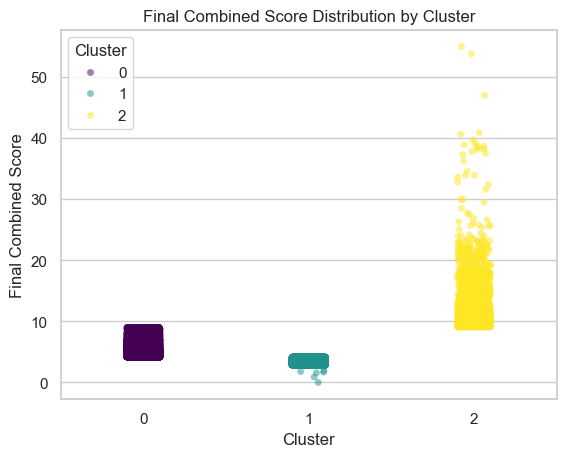

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set_theme(style="whitegrid")

# 클러스터별 점수 분포를 보기 위한 Strip Plot
sns.stripplot(x='Cluster', y='Final_Combined_Score', data=df, hue='Cluster', palette='viridis', jitter=True, alpha=0.5)

# 그래프 제목 및 라벨 설정
plt.title('Final Combined Score Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Final Combined Score')

In [36]:
# Cluster 정보를 바탕으로 Target 변수 생성
# 0: 유지(Cluster 0), 1: 이탈 위험(Cluster 1, 2)
df['Target'] = df['Cluster'].map({0: 1, 1: 0, 2: 1})

# 잘 바뀌었는지 상위 데이터만 살짝 확인해볼까?
print(df[['Final_Combined_Score', 'Cluster', 'Target']].head())

   Final_Combined_Score  Cluster  Target
0                   2.9        1       0
1                   5.0        0       1
2                   3.3        1       0
3                   3.0        1       0
4                   2.9        1       0


In [37]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import accuracy_score

In [38]:
# ============================================================================
# 핵심 1: 불필요한 컬럼 정의
# ============================================================================
target_col = 'Target'  # 정답지
drop_cols = ['Slope_Spend','Slope_Balance','Slope_Count', '발급회원번호', '기준년월',
    'Risk_Flag','Churn_Score_Slope','Churn_Score_Total_Scaled','Final_Combined_Score','Cluster','Target'
    ]
#'이용금액_신용_B0M',  '이용건수_신용_B0M','잔액_B0M'
# ============================================================================
# 핵심 2: 월별로 데이터 쪼개기 (Time Split)
# ============================================================================
# 1) 학습 데이터 (7, 8, 9, 10월)
train_df = df[df['기준년월'].isin([201807, 201808, 201809, 201810])]

# 2) 검증 데이터 (11월) - 모델 채점용
valid_df = df[df['기준년월'] == 201811]

# 3) 실전 예측 데이터 (12월) - 정답(Target)이 없는 미래 데이터
predict_df = df[df['기준년월'] == 201812]

# ============================================================================
# 핵심 3: X(문제), y(정답) 나누기
# ============================================================================
X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

X_predict = predict_df.drop(columns=drop_cols)
predict_ids = predict_df['발급회원번호'] # 결과 매칭용 ID 킵

# 문자열 -> category 변환 (LightGBM 최적화)
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = X_train[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')
        X_predict[col] = X_predict[col].astype('category')

# ============================================================================
# 핵심 4: 모델 학습
# ============================================================================
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


# ============================================================================
# 핵심 5: 12월 고객에 대한 이탈 확률 예측 및 결과 저장
# ============================================================================
pred_prob = model.predict_proba(X_predict)[:, 1]

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

# 결과 정리
final_result = pd.DataFrame({
    '발급회원번호': predict_ids,
    '이탈예측확률': pred_prob
})

print(final_result.sort_values('이탈예측확률', ascending=False).head(10))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[837]	valid_0's binary_logloss: 0.230518
             발급회원번호    이탈예측확률
43763    SYN_149668  0.996950
58967   SYN_1670004  0.995768
153371  SYN_2731044  0.995143
192965   SYN_473310  0.994446
88631   SYN_2006615  0.994353
210125   SYN_661221  0.993249
98915   SYN_2122084  0.990910
53879   SYN_1611411  0.990549
139403  SYN_2579332  0.990290
195209   SYN_498091  0.990282


In [39]:
pred_valid = model.predict(X_valid)
print("검증(11월) 정확도:", accuracy_score(y_valid, pred_valid))

검증(11월) 정확도: 0.9053757542512342


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

# 검증 데이터에 대한 예측값
y_pred = model.predict(X_valid)

# 상세 리포트 출력
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     35213
           1       0.70      0.39      0.50      4893

    accuracy                           0.91     40106
   macro avg       0.81      0.68      0.72     40106
weighted avg       0.89      0.91      0.89     40106



In [41]:
# 1. 학습에 사용할 피처(X)와 정답(y) 분리
# ID성 컬럼과 점수/타겟 관련 컬럼은 제외합니다.
exclude_cols = ['발급회원번호', '기준년월', 'Target', 'Cluster', 'Final_Combined_Score',
                'Churn_Score_Slope', 'Churn_Score_Total_Scaled']

X = df.drop(columns=exclude_cols, errors='ignore')
y = df['Target']

print(f"원본 데이터 분포:\n{y.value_counts()}")

원본 데이터 분포:
Target
0    206944
1     33692
Name: count, dtype: int64


In [42]:
# !pip3 install imblearn

In [43]:
from imblearn.under_sampling import RandomUnderSampler

# 언더샘플링 적용
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"언더샘플링 후 데이터 분포:\n{y_resampled.value_counts()}")

언더샘플링 후 데이터 분포:
Target
0    33692
1    33692
Name: count, dtype: int64


In [44]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
import lightgbm as lgb

# 1. 기존 코드의 핵심 3번: X, y 나누기까지 진행
X_train_raw = train_df.drop(columns=drop_cols)
y_train_raw = train_df[target_col]

X_valid = valid_df.drop(columns=drop_cols)
y_valid = valid_df[target_col]

# 2. [추가] 언더샘플링 적용 (학습 데이터에만!)
# 샘플링 전략을 'auto'로 하면 소수 클래스인 1에 맞춰 0의 개수를 줄입니다.
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_raw, y_train_raw)

print(f"샘플링 전 학습 데이터 (0, 1): {y_train_raw.value_counts().to_dict()}")
print(f"샘플링 후 학습 데이터 (0, 1): {y_train_rus.value_counts().to_dict()}")

# 3. 모델 학습 (핵심 4번)
# 샘플링된 X_train_rus, y_train_rus를 넣어서 학습시킵니다.
model = lgb.LGBMClassifier(n_estimators=1000, random_state=42, verbose=-1)

model.fit(
    X_train_rus, y_train_rus,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# 4. 성능 확인 (Recall 점수 체크)
y_valid_pred = model.predict(X_valid)
print("\n--- 언더샘플링 적용 후 11월 검증 결과 ---")
print(classification_report(y_valid, y_valid_pred))

샘플링 전 학습 데이터 (0, 1): {0: 136338, 1: 24086}
샘플링 후 학습 데이터 (0, 1): {0: 24086, 1: 24086}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.380322

--- 언더샘플링 적용 후 11월 검증 결과 ---
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     35213
           1       0.37      0.81      0.51      4893

    accuracy                           0.81     40106
   macro avg       0.67      0.81      0.69     40106
weighted avg       0.90      0.81      0.84     40106



In [45]:
# ============================================================================
# 1. 하이퍼파라미터 변경 (언더샘플링 데이터에 최적화)
# ============================================================================

# 데이터를 적게 쓰는 만큼, 모델이 너무 깊게 공부하지 못하게 조절할게!
model = lgb.LGBMClassifier(
    n_estimators=500,        # 너무 많으면 과적합되니 조금 줄였어
    learning_rate=0.03,      # 조금 더 천천히, 꼼꼼하게 학습하게 했어
    num_leaves=20,           # 복잡도를 낮춰서 일반화 성능을 높였어
    max_depth=5,             # 트리의 깊이를 제한했어
    min_child_samples=10,    # 리프 노드에 최소한의 데이터가 있게 해서 가지치기를 유도해
    random_state=42,
    verbose=-1
)

# 샘플링된 데이터(X_train_rus, y_train_rus)로 학습!
model.fit(
    X_train_rus, y_train_rus,
    eval_set=[(X_valid, y_valid)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=30)]
)

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.409674


,boosting_type,'gbdt'
,num_leaves,20
,max_depth,5
,learning_rate,0.03
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,10


In [47]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 1. 모델 정의 시에만 verbose=-1을 넣어줘 (이미 위에서 정의했다면 그대로 써도 돼!)
model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    num_leaves=20,
    max_depth=5,
    random_state=42,
    verbose=-1 # 여기서 조용히 학습하라고 미리 말해두는 거야!
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

print("교차 검증 시작!")

for i, (train_idx, val_idx) in enumerate(skf.split(X_train_rus, y_train_rus)):
    X_cv_train, X_cv_val = X_train_rus.iloc[train_idx], X_train_rus.iloc[val_idx]
    y_cv_train, y_cv_val = y_train_rus.iloc[train_idx], y_train_rus.iloc[val_idx]
    
    # [수정 포인트] fit()에서 verbose=-1을 삭제했어!
    model.fit(X_cv_train, y_cv_train)
    
    score = model.score(X_cv_val, y_cv_val)
    cv_results.append(score)
    print(f"{i+1}회차 검증 정확도: {score:.4f}")

print(f"\n평균 교차 검증 정확도: {np.mean(cv_results):.4f}")

교차 검증 시작!
1회차 검증 정확도: 0.8327
2회차 검증 정확도: 0.8321
3회차 검증 정확도: 0.8299
4회차 검증 정확도: 0.8317
5회차 검증 정확도: 0.8284

평균 교차 검증 정확도: 0.8310


In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. 단순히 0, 1로 예측하는 게 아니라 '확률'을 먼저 뽑아봐
y_prob = model.predict_proba(X_valid)[:, 1]

# 2. 기준선(Threshold)을 조절해봐 (기본은 0.5야)
# 이 값을 높이면 Precision(정밀도)이 올라가고, 낮추면 Recall(재현율)이 올라가!
threshold = 0.45 
y_pred_custom = (y_prob >= threshold).astype(int)

print(f"--- 임계값 {threshold} 적용 결과 ---")
print(classification_report(y_valid, y_pred_custom))

--- 임계값 0.45 적용 결과 ---
              precision    recall  f1-score   support

           0       0.97      0.72      0.83     35213
           1       0.30      0.85      0.44      4893

    accuracy                           0.74     40106
   macro avg       0.63      0.78      0.63     40106
weighted avg       0.89      0.74      0.78     40106



In [49]:
###############################################################

In [53]:
from imblearn.under_sampling import RandomUnderSampler

# 유지(0)를 이탈(1)보다 3배 더 많이 남겨두자! (1:3 비율)
# sampling_strategy=0.33은 1/3 비율로 맞추라는 뜻이야.
rus = RandomUnderSampler(sampling_strategy=0.33, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_raw, y_train_raw)

print(f"샘플링 후 데이터 구성: {y_train_rus.value_counts().to_dict()}")

샘플링 후 데이터 구성: {0: 72987, 1: 24086}


In [54]:
from sklearn.metrics import f1_score
import numpy as np

# 1. 모델한테 각 사람이 이탈할 '확률'이 몇 %인지 물어보기
y_prob = model.predict_proba(X_valid)[:, 1]

# 2. 0.1부터 0.9까지 기준(Threshold)을 바꿔가며 점수(F1-score)를 계산해
thresholds = np.arange(0.1, 0.9, 0.05)
scores = [f1_score(y_valid, y_prob >= t) for t in thresholds]

# 3. 그중에서 가장 점수가 높았던 기준점을 '황금 기준선'으로 정해
best_threshold = thresholds[np.argmax(scores)]

print(f"컴퓨터가 찾은 가장 똑똑한 기준선은 {best_threshold:.2f}야!")

컴퓨터가 찾은 가장 똑똑한 기준선은 0.65야!


In [55]:
from sklearn.metrics import classification_report

# 우리가 찾은 '황금 기준선'을 적용해서 최종 예측을 해보자
y_pred_final = (y_prob >= best_threshold).astype(int)

# 최종 성적표 출력!
print(f"--- 최적 임계값 {best_threshold:.2f} 적용 결과 ---")
print(classification_report(y_valid, y_pred_final))

--- 최적 임계값 0.65 적용 결과 ---
              precision    recall  f1-score   support

           0       0.94      0.89      0.92     35213
           1       0.44      0.60      0.51      4893

    accuracy                           0.86     40106
   macro avg       0.69      0.75      0.71     40106
weighted avg       0.88      0.86      0.87     40106



In [56]:
#########################################################

In [59]:
# 1. 모든 빈칸(NaN)을 0으로 채워주기 (평균값으로 채워도 좋아!)
X_train_clean = X_train_raw.fillna(0)

# 2. SMOTE는 글자를 못 읽어! 숫자 데이터만 골라내기
X_train_numeric = X_train_clean.select_dtypes(include=[np.number])

# 3. 정답지(y)도 인덱스를 맞춰줘
y_train_numeric = y_train_raw.loc[X_train_numeric.index]

print("빈칸 제거 및 숫자형 변환 완료!")

빈칸 제거 및 숫자형 변환 완료!


In [60]:
from imblearn.over_sampling import SMOTE

# 이제 깨끗해진 데이터(X_train_numeric)로 다시 뻥튀기!
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_numeric, y_train_numeric)

print(f"샘플링 후 데이터 구성: {y_train_smote.value_counts().to_dict()}")

샘플링 후 데이터 구성: {0: 136338, 1: 68169}


In [61]:
# 11월 검증 데이터도 똑같이 숫자만 골라줘야 해
X_valid_numeric = X_valid.select_dtypes(include=[np.number]).fillna(0)

# 모델 학습
model.fit(X_train_smote, y_train_smote)

# 확률 예측 및 최적 임계값 찾기
y_prob = model.predict_proba(X_valid_numeric)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.05)
best_t = thresholds[np.argmax([f1_score(y_valid, y_prob >= t) for t in thresholds])]

# 최종 성적표 출력
y_pred_final = (y_prob >= best_t).astype(int)
print(f"--- 최적 임계값 {best_t:.2f} 적용 결과 ---")
print(classification_report(y_valid, y_pred_final))

--- 최적 임계값 0.25 적용 결과 ---
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     35213
           1       0.38      0.63      0.47      4893

    accuracy                           0.83     40106
   macro avg       0.66      0.74      0.69     40106
weighted avg       0.87      0.83      0.85     40106

